In [0]:
# Check GPU enable on Colab
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
!curl https://course.fast.ai/setup/colab | bash

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   321  100   321    0     0   1521      0 --:--:-- --:--:-- --:--:--  1521
Updating fastai...
featuretools 0.4.1 has requirement pandas>=0.23.0, but you'll have pandas 0.22.0 which is incompatible.
datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.
Done.


## Setup

In [0]:
from fastai.tabular import *

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Prepare dataset (Clean data)

You can download dataset from [here](http://files.fast.ai/part2/lesson14/rossmann.tgz)

In [0]:
path = Config.data_path()/"rossmann"
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/root/.fastai/data/rossmann')

In [0]:
path.ls()

[PosixPath('/root/.fastai/data/rossmann/rossmann.tgz')]

In [0]:
!tar zxvf {path}/rossmann.tgz -C {path}

googletrend.csv
sample_submission.csv
state_names.csv
store.csv
store_states.csv
test.csv
train.csv
weather.csv


In [0]:
path.ls()

[PosixPath('/root/.fastai/data/rossmann/store.csv'),
 PosixPath('/root/.fastai/data/rossmann/weather.csv'),
 PosixPath('/root/.fastai/data/rossmann/store_states.csv'),
 PosixPath('/root/.fastai/data/rossmann/state_names.csv'),
 PosixPath('/root/.fastai/data/rossmann/sample_submission.csv'),
 PosixPath('/root/.fastai/data/rossmann/rossmann.tgz'),
 PosixPath('/root/.fastai/data/rossmann/googletrend.csv'),
 PosixPath('/root/.fastai/data/rossmann/test.csv'),
 PosixPath('/root/.fastai/data/rossmann/train.csv')]

In [0]:
table_names = ["train", "store", "store_states", "state_names", "googletrend", "weather", "test"]
tables = [pd.read_csv(path/f"{fname}.csv", low_memory=False) for fname in table_names]

In [0]:
train, store, store_states, state_names, googletrend, weather, test = tables

In [0]:
len(train), len(test)

(1017209, 41088)

Turn `StateHoliday` to booleans, to make them more convenient for modeling.

In [0]:
train.StateHoliday = train.StateHoliday != '0'
test.StateHoliday = test.StateHoliday != '0'

join_df function is joining tables on specific fields.



In [0]:
def join_df(left, right, left_on, right_on=None, suffix="_y"):
    if right_on is None: right_on = left_on
    return left.merge(right, how="left",
                      left_on=left_on, 
                      right_on=right_on,
                      suffixes=("", suffix))

In [0]:
# Join weather and state names
weather = join_df(weather, state_names, "file", "StateName")

Selecting rows w/ statename "NI" by using a boolean list `googletrend.State == "NI"` and selecting "State".

In [0]:
googletrend["Date"] = googletrend.week.str.split(" - ", expand=True)[0]
googletrend["State"] = googletrend.file.str.split("_", expand=True)[2]
googletrend.loc[googletrend.State == "NI", "State"] = "HB,NI"

In [0]:
def add_datepart(df, fldname, drop=True, time=False):
    "Add columns relevant to a date."
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64
        
    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
        
    targ_pre = re.sub("[Dd]ate$", "", fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop: df.drop(fldname, axis=1, inplace=True)

In [0]:
add_datepart(weather, "Date", drop=False)

In [0]:
add_datepart(googletrend, "Date", drop=False)

In [0]:
add_datepart(train, "Date", drop=False)

In [0]:
add_datepart(test, "Date", drop=False)

The Google trends data has a special category for the whole of the Germany  - we'll pull that out so we can use it explicity.

In [0]:
trend_de = googletrend[googletrend.file == "Rossmann_DE"]

In [0]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [0]:
store_states.head()

,Store,State
0,1,HE
1,2,TH
2,3,NW
3,4,BE
4,5,SN


In [0]:
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,...,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
0,1,5,2015-07-31,5263,555,1,1,False,1,2015,...,31,4,212,True,False,False,False,False,False,1438300800
1,2,5,2015-07-31,6064,625,1,1,False,1,2015,...,31,4,212,True,False,False,False,False,False,1438300800
2,3,5,2015-07-31,8314,821,1,1,False,1,2015,...,31,4,212,True,False,False,False,False,False,1438300800
3,4,5,2015-07-31,13995,1498,1,1,False,1,2015,...,31,4,212,True,False,False,False,False,False,1438300800
4,5,5,2015-07-31,4822,559,1,1,False,1,2015,...,31,4,212,True,False,False,False,False,False,1438300800


In [0]:
test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,...,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
0,1,1,4,2015-09-17,1.0,1,False,0,2015,9,...,17,3,260,False,False,False,False,False,False,1442448000
1,2,3,4,2015-09-17,1.0,1,False,0,2015,9,...,17,3,260,False,False,False,False,False,False,1442448000
2,3,7,4,2015-09-17,1.0,1,False,0,2015,9,...,17,3,260,False,False,False,False,False,False,1442448000
3,4,8,4,2015-09-17,1.0,1,False,0,2015,9,...,17,3,260,False,False,False,False,False,False,1442448000
4,5,9,4,2015-09-17,1.0,1,False,0,2015,9,...,17,3,260,False,False,False,False,False,False,1442448000


In [0]:
store = join_df(store, store_states, 'Store')
len(store[store.State.isnull()])

0

In [0]:
joined = join_df(train, store, "Store")
joined_test = join_df(test, store, "Store")
len(joined[joined.StoreType.isnull()]), len(joined_test[joined_test.StoreType.isnull()])

(0, 0)

In [0]:
joined = join_df(joined, googletrend, ["State","Year", "Week"])
joined_test = join_df(joined_test, googletrend, ["State","Year", "Week"])
len(joined[joined.trend.isnull()]),len(joined_test[joined_test.trend.isnull()])

(0, 0)

In [0]:
joined = joined.merge(trend_de, 'left', ["Year", "Week"], suffixes=('', '_DE'))
joined_test = joined_test.merge(trend_de, 'left', ["Year", "Week"], suffixes=('', '_DE'))
len(joined[joined.trend_DE.isnull()]),len(joined_test[joined_test.trend_DE.isnull()])

(0, 0)

In [0]:
joined = join_df(joined, weather, ["State","Date"])
joined_test = join_df(joined_test, weather, ["State","Date"])
len(joined[joined.Mean_TemperatureC.isnull()]),len(joined_test[joined_test.Mean_TemperatureC.isnull()])

(0, 0)

In [0]:
for df in (joined, joined_test):
    for c in df.columns:
        if c.endswith("_y"):
            if c in df.columns:
                df.drop(c, inplace=True, axis=1)

Fill missing values to avoid complications with `NA`s. `NA`stand for not available that is how Pandas indicates missing values; many models have problems when missing value are present, so it's always important to think about how to deal with them.

In these cases, we are picking an arbitary single value that doesn't otherwise appear in the data.


In [0]:
joined.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,...,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees,StateName
0,1,5,2015-07-31,5263,555,1,1,False,1,2015,...,15.0,10.0,24,11,NaN,0.0,1.0,Fog,13,Hessen
1,2,5,2015-07-31,6064,625,1,1,False,1,2015,...,10.0,10.0,14,11,NaN,0.0,4.0,Fog,309,Thueringen
2,3,5,2015-07-31,8314,821,1,1,False,1,2015,...,14.0,10.0,14,5,NaN,0.0,2.0,Fog,354,NordrheinWestfalen
3,4,5,2015-07-31,13995,1498,1,1,False,1,2015,...,10.0,10.0,23,16,NaN,0.0,6.0,NaN,282,Berlin
4,5,5,2015-07-31,4822,559,1,1,False,1,2015,...,10.0,10.0,14,11,NaN,0.0,4.0,NaN,290,Sachsen


In [0]:
joined_test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,...,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees,StateName
0,1,1,4,2015-09-17,1.0,1,False,0,2015,9,...,12.0,7.0,29,14,NaN,7.11,6.0,Rain,191,Hessen
1,2,3,4,2015-09-17,1.0,1,False,0,2015,9,...,12.0,8.0,37,26,53.0,3.05,6.0,Rain,187,NordrheinWestfalen
2,3,7,4,2015-09-17,1.0,1,False,0,2015,9,...,10.0,2.0,29,14,45.0,0.76,5.0,Rain,209,SchleswigHolstein
3,4,8,4,2015-09-17,1.0,1,False,0,2015,9,...,10.0,2.0,29,14,45.0,0.76,5.0,Rain,209,SchleswigHolstein
4,5,9,4,2015-09-17,1.0,1,False,0,2015,9,...,12.0,8.0,37,26,53.0,3.05,6.0,Rain,187,NordrheinWestfalen


In [0]:
for df in (joined,joined_test):
    df["CompetitionOpenSinceYear"] = df.CompetitionOpenSinceYear.fillna(1900).astype(np.int32)
    df["CompetitionOpenSinceMonth"] = df.CompetitionOpenSinceMonth.fillna(1).astype(np.int32)
    df["Promo2SinceYear"] = df.Promo2SinceYear.fillna(1900).astype(np.int32)
    df["Promo2SinceWeek"] = df.Promo2SinceWeek.fillna(1).astype(np.int32)

In [0]:
for df in (joined,joined_test):
    df["CompetitionOpenSince"] = pd.to_datetime(dict(year=df.CompetitionOpenSinceYear, 
                                                     month=df.CompetitionOpenSinceMonth, day=15))
    df["CompetitionDaysOpen"] = df.Date.subtract(df.CompetitionOpenSince).dt.days

In [0]:
for df in (joined,joined_test):
    df.loc[df.CompetitionDaysOpen<0, "CompetitionDaysOpen"] = 0
    df.loc[df.CompetitionOpenSinceYear<1990, "CompetitionDaysOpen"] = 0

In [0]:
for df in (joined,joined_test):
    df["CompetitionMonthsOpen"] = df["CompetitionDaysOpen"]//30
    df.loc[df.CompetitionMonthsOpen>24, "CompetitionMonthsOpen"] = 24
joined.CompetitionMonthsOpen.unique()

array([24,  3, 19,  9,  0, 16, 17,  7, 15, 22, 11, 13,  2, 23, 12,  4, 10,  1, 14, 20,  8, 18,  6, 21,  5])

In [0]:
!pip3 install isoweek

In [0]:
from isoweek import Week

In [0]:
for df in (joined,joined_test):
    df["Promo2Since"] = pd.to_datetime(df.apply(lambda x: Week(
        x.Promo2SinceYear, x.Promo2SinceWeek).monday(), axis=1))
    df["Promo2Days"] = df.Date.subtract(df["Promo2Since"]).dt.days

In [0]:
for df in (joined,joined_test):
    df.loc[df.Promo2Days<0, "Promo2Days"] = 0
    df.loc[df.Promo2SinceYear<1990, "Promo2Days"] = 0
    df["Promo2Weeks"] = df["Promo2Days"]//7
    df.loc[df.Promo2Weeks<0, "Promo2Weeks"] = 0
    df.loc[df.Promo2Weeks>25, "Promo2Weeks"] = 25
    df.Promo2Weeks.unique()

In [0]:
joined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 80 columns):
Store                         1017209 non-null int64
DayOfWeek                     1017209 non-null int64
Date                          1017209 non-null datetime64[ns]
Sales                         1017209 non-null int64
Customers                     1017209 non-null int64
Open                          1017209 non-null int64
Promo                         1017209 non-null int64
StateHoliday                  1017209 non-null bool
SchoolHoliday                 1017209 non-null int64
Year                          1017209 non-null int64
Month                         1017209 non-null int64
Week                          1017209 non-null int64
Day                           1017209 non-null int64
Dayofweek                     1017209 non-null int64
Dayofyear                     1017209 non-null int64
Is_month_end                  1017209 non-null bool
Is_month_start                10

In [0]:
joined_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41088 entries, 0 to 41087
Data columns (total 79 columns):
Id                            41088 non-null int64
Store                         41088 non-null int64
DayOfWeek                     41088 non-null int64
Date                          41088 non-null datetime64[ns]
Open                          41077 non-null float64
Promo                         41088 non-null int64
StateHoliday                  41088 non-null bool
SchoolHoliday                 41088 non-null int64
Year                          41088 non-null int64
Month                         41088 non-null int64
Week                          41088 non-null int64
Day                           41088 non-null int64
Dayofweek                     41088 non-null int64
Dayofyear                     41088 non-null int64
Is_month_end                  41088 non-null bool
Is_month_start                41088 non-null bool
Is_quarter_end                41088 non-null bool
Is_quarter_start 

In [0]:
joined.to_pickle(path/"joined")
joined_test.to_pickle(path/"joined_test")

### Durations

It is comon when working with time series data to extract data that explains relationships across rows as opposed to columns,

* Running averages
* Time until next event
* Time since last event

This is often difficult to do with most table manipulation frameworks, since they are designed to work with relationships across columns. As such, we've created a class to handle this type of data.

In [0]:
def get_elapsed(fld, pre):
    day1 = np.timedelta64(1, 'D')
    last_date = np.datetime64()
    last_store = 0
    res = []

    for s,v,d in zip(df.Store.values,df[fld].values, df.Date.values):
        if s != last_store:
            last_date = np.datetime64()
            last_store = s
        if v: last_date = d
        res.append(((d-last_date).astype('timedelta64[D]') / day1))
    df[pre+fld] = res

In [0]:
columns = ["Date", "Store", "Promo", "StateHoliday", "SchoolHoliday"]

In [0]:
df = train[columns].append(test[columns])

In [0]:
fld = 'SchoolHoliday'
df = df.sort_values(['Store', 'Date'])
get_elapsed(fld, 'After')
df = df.sort_values(['Store', 'Date'], ascending=[True, False])
get_elapsed(fld, 'Before')

In [0]:
fld = 'StateHoliday'
df = df.sort_values(['Store', 'Date'])
get_elapsed(fld, 'After')
df = df.sort_values(['Store', 'Date'], ascending=[True, False])
get_elapsed(fld, 'Before')

In [0]:
fld = 'Promo'
df = df.sort_values(['Store', 'Date'])
get_elapsed(fld, 'After')
df = df.sort_values(['Store', 'Date'], ascending=[True, False])
get_elapsed(fld, 'Before')

In [0]:
df = df.set_index("Date")

In [0]:
columns = ['SchoolHoliday', 'StateHoliday', 'Promo']


In [0]:
for o in ["Before", "After"]:
    for p in columns:
        a = o + p
        df[a] = df[a].fillna(0).astype(int)

In [0]:
bwd = df[['Store']+columns].sort_index().groupby("Store").rolling(7, min_periods=1).sum()

In [0]:
fwd = df[['Store']+columns].sort_index(ascending=False
                                      ).groupby("Store").rolling(7, min_periods=1).sum()


In [0]:
bwd.drop("Store", 1, inplace=True)
bwd.reset_index(inplace=True)

In [0]:
fwd.drop("Store", 1, inplace=True)
fwd.reset_index(inplace=True)

In [0]:
df.reset_index(inplace=True)

In [0]:
df = df.merge(bwd, 'left', ['Date', 'Store'], suffixes=['', '_bw'])
df = df.merge(fwd, 'left', ['Date', 'Store'], suffixes=['', '_fw'])

In [0]:
df.drop(columns, 1, inplace=True)

In [0]:
df.head()

,Date,Store,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday,BeforeStateHoliday,AfterPromo,BeforePromo,SchoolHoliday_bw,StateHoliday_bw,Promo_bw,SchoolHoliday_fw,StateHoliday_fw,Promo_fw
0,2015-09-17,1,13,0,105,0,0,0,0.0,0.0,4.0,0.0,0.0,1.0
1,2015-09-16,1,12,0,104,0,0,0,0.0,0.0,3.0,0.0,0.0,2.0
2,2015-09-15,1,11,0,103,0,0,0,0.0,0.0,2.0,0.0,0.0,3.0
3,2015-09-14,1,10,0,102,0,0,0,0.0,0.0,1.0,0.0,0.0,4.0
4,2015-09-13,1,9,0,101,0,9,-1,0.0,0.0,0.0,0.0,0.0,4.0


In [0]:
df.to_pickle(path/"df")

In [0]:
df["Date"] = pd.to_datetime(df.Date)

In [0]:
df.columns

Index(['Date', 'Store', 'AfterSchoolHoliday', 'BeforeSchoolHoliday',
       'AfterStateHoliday', 'BeforeStateHoliday', 'AfterPromo', 'BeforePromo',
       'SchoolHoliday_bw', 'StateHoliday_bw', 'Promo_bw', 'SchoolHoliday_fw',
       'StateHoliday_fw', 'Promo_fw'],
      dtype='object')

In [0]:
joined = pd.read_pickle(path/"joined")
joined_test = pd.read_pickle(path/f"joined_test")

In [0]:
joined = join_df(joined, df, ["Store", "Date"])

In [0]:
joined_test = join_df(joined_test, df, ["Store", "Date"])

In [0]:
joined = joined[joined.Sales != 0]

In [0]:
joined.reset_index(inplace=True)

In [0]:
joined_test.reset_index(inplace=True)

In [0]:
joined.to_pickle(path/"train_clean")

In [0]:
joined_test.to_pickle(path/"test_clean")

## Data preparation

In [0]:
path = Config().data_path()/"rossmann"

In [0]:
path.ls()

[PosixPath('/root/.fastai/data/rossmann/test_clean'),
 PosixPath('/root/.fastai/data/rossmann/store.csv'),
 PosixPath('/root/.fastai/data/rossmann/weather.csv'),
 PosixPath('/root/.fastai/data/rossmann/store_states.csv'),
 PosixPath('/root/.fastai/data/rossmann/state_names.csv'),
 PosixPath('/root/.fastai/data/rossmann/sample_submission.csv'),
 PosixPath('/root/.fastai/data/rossmann/joined_test'),
 PosixPath('/root/.fastai/data/rossmann/rossmann.tgz'),
 PosixPath('/root/.fastai/data/rossmann/joined'),
 PosixPath('/root/.fastai/data/rossmann/googletrend.csv'),
 PosixPath('/root/.fastai/data/rossmann/train_clean'),
 PosixPath('/root/.fastai/data/rossmann/test.csv'),
 PosixPath('/root/.fastai/data/rossmann/df'),
 PosixPath('/root/.fastai/data/rossmann/train.csv')]

In [0]:
train_df = pd.read_pickle(path/"train_clean")

In [0]:
train_df.head().T

,0,1,2,3,4
index,0,1,2,3,4
Store,1,2,3,4,5
DayOfWeek,5,5,5,5,5
Date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
Sales,5263,6064,8314,13995,4822
Customers,555,625,821,1498,559
Open,1,1,1,1,1
Promo,1,1,1,1,1
StateHoliday,False,False,False,False,False
SchoolHoliday,1,1,1,1,1


In [0]:
n = len(train_df); n

844338

### Experimenting with a sample

In [0]:
idx = np.random.permutation(range(n))[:2000]
idx.sort()

In [0]:
small_train_df = train_df.iloc[idx[:1000]]
small_test_df = train_df.iloc[idx[1000:]]

In [0]:
small_cont_vars = ["CompetitionDistance", "Mean_Humidity"]
small_cat_vars = ["Store", "DayOfWeek", "PromoInterval"]

In [0]:
small_train_df = small_train_df[small_cat_vars + small_cont_vars + ['Sales']]
small_test_df = small_test_df[small_cat_vars + small_cont_vars + ['Sales']]

In [0]:
small_train_df.head()

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales
67,68,5,"Mar,Jun,Sept,Dec",250.0,61,11187
255,256,5,"Mar,Jun,Sept,Dec",80.0,61,11536
518,520,5,"Mar,Jun,Sept,Dec",6900.0,61,5170
1024,1027,5,"Jan,Apr,Jul,Oct",190.0,50,16273
1664,553,4,"Jan,Apr,Jul,Oct",3040.0,60,8898


In [0]:
small_test_df.head()

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales
431893,1043,5,NaN,420.0,48,9183
432380,418,4,"Feb,May,Aug,Nov",1060.0,49,4320
432500,539,4,"Jan,Apr,Jul,Oct",770.0,64,10999
432565,604,4,NaN,10950.0,64,6752
432789,828,4,NaN,3290.0,42,4611


In [0]:
categorify = Categorify(small_cat_vars, small_cont_vars)

In [0]:
categorify(small_train_df)

In [0]:
categorify(small_test_df, test=True)

In [0]:
small_test_df.head()

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales
431893,1043.0,5,NaN,420.0,48,9183
432380,418.0,4,"Feb,May,Aug,Nov",1060.0,49,4320
432500,NaN,4,"Jan,Apr,Jul,Oct",770.0,64,10999
432565,NaN,4,NaN,10950.0,64,6752
432789,NaN,4,NaN,3290.0,42,4611


In [0]:
small_train_df.PromoInterval.cat.categories

Index(['Feb,May,Aug,Nov', 'Jan,Apr,Jul,Oct', 'Mar,Jun,Sept,Dec'], dtype='object')

In [0]:
small_train_df["PromoInterval"].cat.codes[:5]

67      2
255     2
518     2
1024    1
1664    1
dtype: int8

In [0]:
fill_missing = FillMissing(small_cat_vars, small_cont_vars)
fill_missing(small_train_df)
fill_missing(small_test_df, test=True)

In [0]:
small_train_df[small_train_df['CompetitionDistance_na'] == True]

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales,CompetitionDistance_na
29951,879,3,"Feb,May,Aug,Nov",2310.0,67,4698,True


### Preparing full data set

In [0]:
train_df = pd.read_pickle(path/"train_clean")
test_df = pd.read_pickle(path/"test_clean")

In [0]:
len(train_df), len(test_df)

(844338, 41088)

In [0]:
procs = [FillMissing, Categorify, Normalize]

In [0]:
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen',
    'Promo2Weeks', 'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear',
    'State', 'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw', 'StateHoliday_bw',
    'SchoolHoliday_fw', 'SchoolHoliday_bw']

cont_vars = ['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday']

In [0]:
dep_var = "Sales"
df = train_df[cat_vars + cont_vars + [dep_var, "Date"]].copy()

In [0]:
test_df["Date"].min(), test_df["Date"].max()

(Timestamp('2015-08-01 00:00:00'), Timestamp('2015-09-17 00:00:00'))

In [0]:
cut = train_df["Date"][(train_df["Date"] == train_df["Date"][len(test_df)])].index.max()

In [0]:
cut

41395

In [0]:
valid_idx = range(cut)

In [0]:
df[dep_var].head()

0     5263
1     6064
2     8314
3    13995
4     4822
Name: Sales, dtype: int64

In [0]:
data = (TabularList.from_df(df, 
                            path=path, 
                            cat_names=cat_vars,
                            cont_names=cont_vars,
                            procs=procs)
        .split_by_idx(valid_idx)
        .label_from_df(cols=dep_var, label_cls=FloatList, log=True)
        .add_test(TabularList.from_df(test_df, path=path, cat_names=cat_vars, cont_names=cont_vars))
        .databunch())

In [0]:
doc(FloatList)

## Build Model

In [0]:
max_log_y = np.log(np.max(train_df["Sales"]) * 1.2)

In [0]:
y_range = torch.tensor([0, max_log_y], device=defaults.device)

In [0]:
learn = tabular_learner(data, 
                        layers=[1000,500],
                        ps=[0.001,0.01],
                        emb_drop=0.04, 
                        y_range=y_range,
                        metrics=exp_rmspe)

In [0]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(1116, 81)
    (1): Embedding(8, 5)
    (2): Embedding(4, 3)
    (3): Embedding(13, 7)
    (4): Embedding(32, 11)
    (5): Embedding(3, 3)
    (6): Embedding(26, 10)
    (7): Embedding(27, 10)
    (8): Embedding(5, 4)
    (9): Embedding(4, 3)
    (10): Embedding(4, 3)
    (11): Embedding(24, 9)
    (12): Embedding(9, 5)
    (13): Embedding(13, 7)
    (14): Embedding(53, 15)
    (15): Embedding(22, 9)
    (16): Embedding(7, 5)
    (17): Embedding(7, 5)
    (18): Embedding(4, 3)
    (19): Embedding(4, 3)
    (20): Embedding(9, 5)
    (21): Embedding(9, 5)
    (22): Embedding(3, 3)
    (23): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.04)
  (bn_cont): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=233, out_features=1000, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

In [0]:
len(data.train_ds.cont_names)

16

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


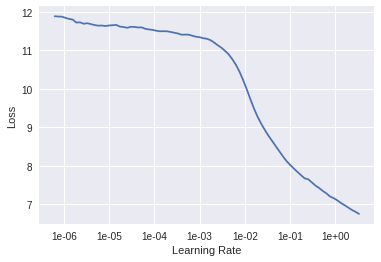

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(5, 1e-3, wd=0.2)

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.021511,0.026583,0.148513,04:42
1,0.022195,0.016840,0.131647,04:32
2,0.015971,0.016073,0.122010,04:40
3,0.012897,0.014666,0.114045,04:44
4,0.010183,0.010780,0.101994,04:32


In [0]:
learn.save("stage-1")

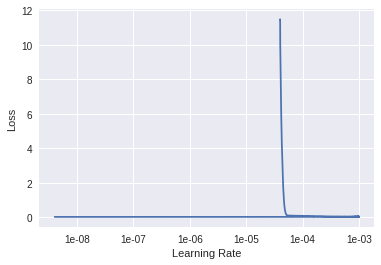

In [0]:
learn.recorder.plot()

In [0]:
learn.unfreeze()

In [0]:
learn.fit_one_cycle(5, 3e-4)

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.012287,0.014035,0.112474,04:25
1,0.012752,0.012634,0.111286,04:38
2,0.011328,0.013838,0.113295,04:30
3,0.011134,0.012829,0.111159,04:48
4,0.009843,0.013476,0.109582,04:41
